<a href="https://colab.research.google.com/github/ciepielajan/Tweets_Teslas_Stock/blob/main/Tweets_Teslas_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import json
import csv
import tweepy
import re
import pandas as pd
from textblob import TextBlob
plt.style.use("seaborn") 
import warnings
warnings.filterwarnings('ignore')

`zdefiniowanie hastagu spółki wg którego zostaną przeszukane tweety`

In [2]:
consumer_key = 'R7DGimRNkT11sbngA0MRqLmNE'
consumer_secret = 'w5Axtw43feejwgmPIhqPhPOt1aHso1Guw1yuFwlmijtlh0vguK'
access_token = '1279486577656295425-l3gaKqKuHQdKl44rPXUc0WYcc26wgq'
access_token_secret = '80dGAdcx6LuoWM1mSt669V5NESP0EOuX1dK8Mianjqxi2'

In [3]:
# hashtag_phrase ="tesla"
hashtag_phrase ="#TSLA"

In [4]:
#create authentication for accessing Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

#initialize Tweepy API
api = tweepy.API(auth)

`Pobranie surowych danych`

In [5]:
data = []
for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets',  lang="en", tweet_mode='extended').items(1000):
    data.append(
        [tweet.id_str,
        tweet.created_at,   # create post
        tweet.full_text.replace('\n',' '),   #text
        # tweet.user.screen_name,      #user name
        # [e['text'] for e in tweet._json['entities']['hashtags']],   #hastags
        # tweet.user.followers_count            # followers
        ]    )

In [56]:
df_tweets = pd.DataFrame(data, columns=["tweet_id","date","tweet_row"])
df_tweets.head(5)

,tweet_id,date,tweet_row
0,1377152482057482242,2021-03-31 06:55:12,"Also, $TSLA is ALMOST ALWAYS on watch for Day ..."
1,1377147089730240516,2021-03-31 06:33:47,@Tesla @elonmusk #Tesla Summon is a joke in UK...
2,1377140977631068162,2021-03-31 06:09:29,"📈Tesla Growth 2020 Q1 Deliveries 88,400 20..."
3,1377139808619782145,2021-03-31 06:04:51,Indian investors hunting for US stocks after s...
4,1377131862745776130,2021-03-31 05:33:16,@SawyerMerritt ONE MILLION DELIVERIES!! Muahah...


In [57]:
print("ilość tweetów:", len(df_tweets.index))
print("od:", df_tweets.date.min())
print("do:", df_tweets.date.max())

ilość tweetów: 1000
od: 2021-03-25 14:51:48
do: 2021-03-31 06:55:12


`oczyszczenie tweetów przez usunięcie wszystkiego co nie jest słowem`

In [8]:
def clear_tweet(sentence):
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag - na początku żeby nie usunął później placeholderów

    #placehodlery
    sentence = re.sub('[\w\.-]+@[\w\.-]+', '  ', sentence)  # maile
    sentence = re.sub('(https://|http://|)+[A-Za-z]+\.+[A-Za-z]+(\S)+', '  ', sentence)  # linki
    sentence = re.sub('([0-9]{4}|[0-9]{2}|[0-9]{1})(\.|\-|\/)([0-9]{4}|[0-9]{2}|[0-9]{1})(\.|\-|\/)([0-9]{4}|[0-9]{2}|[0-9]{1})', '  ', sentence)  # date
    sentence = re.sub('[0-9]{1,2}(\:|am|pm| am| pm)([0-9]{1,2}|\:|am|pm|)([0-9]{1,2}|\:|am|pm| am| pm|)(([0-9]{1,10})?)', '  ', sentence)  # time
    sentence = re.sub('\s\d+(,\d+)*(\.\d+)?(\%)?\s', '  ', sentence)  # number
    sentence = re.sub('@[A-Za-z0-9\.]+', ' ', sentence)  # @montion
    sentence = re.sub('#[A-Za-z0-9]+', ' ', sentence)  # #hastag

    #czyszczenie
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   nie usuwać <PLACEHOLDERÓW>
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters
    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = re.sub("\s+", " ", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:

    # sentence = " ".join(sentence.split(" "))  # Remove ONLY DUPLICATE spaces:
    # sentence = " ".join(sentence) # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()

    return sentence

In [58]:
df_tweets["tweet_clean"] = df_tweets["tweet_row"].apply(lambda x: clear_tweet(x))
df_tweets

,tweet_id,date,tweet_row,tweet_clean
0,1377152482057482242,2021-03-31 06:55:12,"Also, $TSLA is ALMOST ALWAYS on watch for Day ...",also tsla is almost always on watch for day tr...
1,1377147089730240516,2021-03-31 06:33:47,@Tesla @elonmusk #Tesla Summon is a joke in UK...,summon is joke in uk
2,1377140977631068162,2021-03-31 06:09:29,"📈Tesla Growth 2020 Q1 Deliveries 88,400 20...",tesla growth deliveries delivery estimates yoy...
3,1377139808619782145,2021-03-31 06:04:51,Indian investors hunting for US stocks after s...,indian investors hunting for us stocks after s...
4,1377131862745776130,2021-03-31 05:33:16,@SawyerMerritt ONE MILLION DELIVERIES!! Muahah...,one million deliveries muahaha
...,...,...,...,...
995,1375099169401102355,2021-03-25 14:56:04,1. Cryptocurrencies: neo-normal. 2. #BTC rever...,cryptocurrencies neonormal reversal trend patt...
996,1375098477206597632,2021-03-25 14:53:19,Entry Alert: BTO $RH 3/26 $530.00C @ $1.25 🚩 ...,entry alert bto rh btc tsla spy
997,1375098436354199552,2021-03-25 14:53:09,What should I buy today? More #TSLA #BTC or #D...,what should buy today more or
998,1375098106749014028,2021-03-25 14:51:51,#REAL Reason why #TSLA is Buying #Bitcoin | #M...,reason why is buying manipulation tsla buying ...


`Obliczenie sentymentu`

In [59]:
# domyślna forma
df_tweets["sentiment_polarity"] = df_tweets["tweet_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_tweets["sentiment_subjectivity"] = df_tweets["tweet_clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df_tweets

,tweet_id,date,tweet_row,tweet_clean,sentiment_polarity,sentiment_subjectivity
0,1377152482057482242,2021-03-31 06:55:12,"Also, $TSLA is ALMOST ALWAYS on watch for Day ...",also tsla is almost always on watch for day tr...,0.005357,0.271429
1,1377147089730240516,2021-03-31 06:33:47,@Tesla @elonmusk #Tesla Summon is a joke in UK...,summon is joke in uk,0.000000,0.000000
2,1377140977631068162,2021-03-31 06:09:29,"📈Tesla Growth 2020 Q1 Deliveries 88,400 20...",tesla growth deliveries delivery estimates yoy...,0.600000,0.900000
3,1377139808619782145,2021-03-31 06:04:51,Indian investors hunting for US stocks after s...,indian investors hunting for us stocks after s...,0.150000,0.550000
4,1377131862745776130,2021-03-31 05:33:16,@SawyerMerritt ONE MILLION DELIVERIES!! Muahah...,one million deliveries muahaha,0.000000,0.000000
...,...,...,...,...,...,...
995,1375099169401102355,2021-03-25 14:56:04,1. Cryptocurrencies: neo-normal. 2. #BTC rever...,cryptocurrencies neonormal reversal trend patt...,0.000000,0.000000
996,1375098477206597632,2021-03-25 14:53:19,Entry Alert: BTO $RH 3/26 $530.00C @ $1.25 🚩 ...,entry alert bto rh btc tsla spy,0.000000,0.000000
997,1375098436354199552,2021-03-25 14:53:09,What should I buy today? More #TSLA #BTC or #D...,what should buy today more or,0.500000,0.500000
998,1375098106749014028,2021-03-25 14:51:51,#REAL Reason why #TSLA is Buying #Bitcoin | #M...,reason why is buying manipulation tsla buying ...,0.000000,0.000000


`Analiza sentymentu`

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

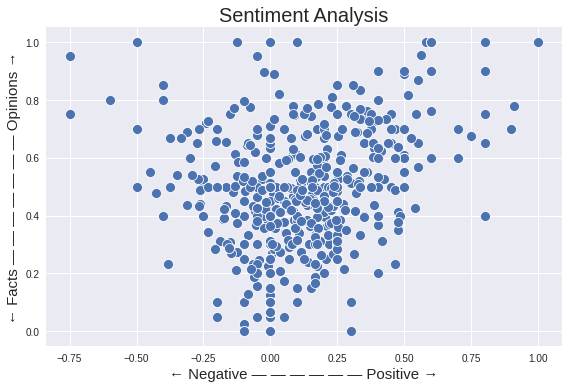

In [60]:
tweet_polarity = df_tweets["sentiment_polarity"].values
tweet_subjectivity = df_tweets["sentiment_subjectivity"].values

sns.scatterplot(tweet_polarity, # X-axis
                tweet_subjectivity,  # Y-axis
                s=100);

plt.title("Sentiment Analysis", fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.tight_layout()

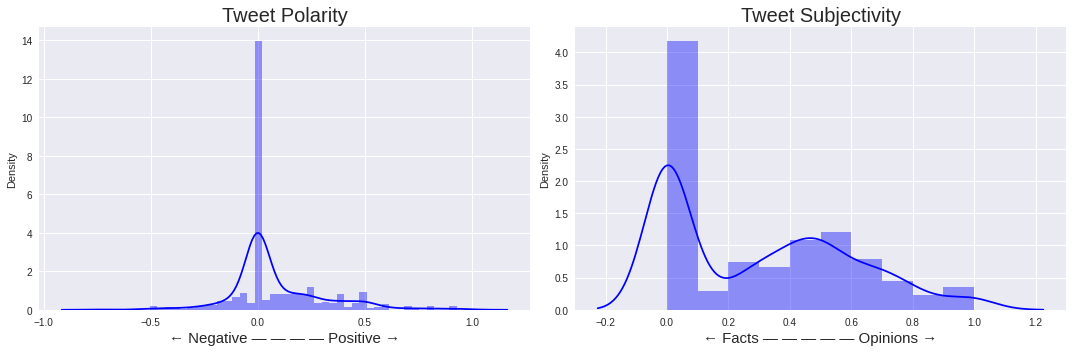

In [61]:
f, axs = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(tweet_polarity, color="b", ax=axs[0])
axs[0].set_title("Tweet Polarity", fontsize = 20)
axs[0].set_xlabel('← Negative — — — — Positive →', fontsize=15)
sns.distplot(tweet_subjectivity, color="b", ax=axs[1])
axs[1].set_title("Tweet Subjectivity", fontsize = 20)
axs[1].set_xlabel('← Facts — — — — — Opinions →', fontsize=15)

plt.tight_layout()

`zgupowanie sentymentów wg dnia`

In [62]:
df_tweets = df_tweets.set_index("date")
df_sentiment = df_tweets.resample('D').sum()
df_sentiment

,sentiment_polarity,sentiment_subjectivity
date,,
2021-03-25,1.791181,17.062880
2021-03-26,19.070965,68.783306
2021-03-27,9.665745,33.473634
2021-03-28,10.107882,33.943385
2021-03-29,17.637366,66.980581
2021-03-30,22.203083,69.303650
2021-03-31,2.781011,9.109023


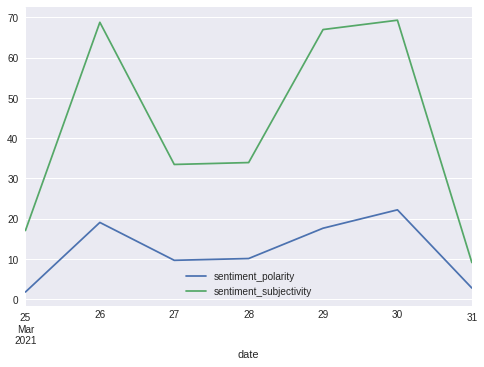

In [64]:
df_sentiment.plot()

`pobranie danych giełdowych spółki`

In [65]:
import pandas_datareader.data as web

min = df_tweets.index.min()
max = df_tweets.index.max()

df_TSLA = web.DataReader(name="TSLA", data_source="stooq", start=min, end=max)
df_TSLA

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-30,601.75,637.66,591.01,635.62,39432359
2021-03-29,615.64,616.48,596.02,611.29,28636985
2021-03-26,641.87,643.82,599.89,618.71,33852827
2021-03-25,613.00,645.50,609.50,640.39,39224850


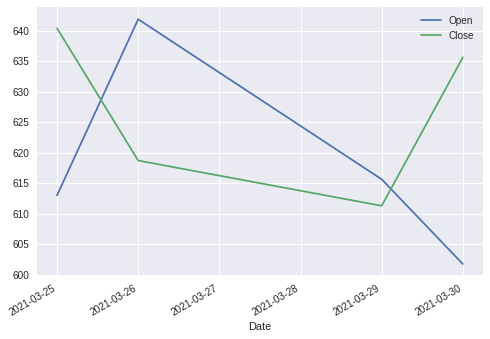

In [66]:
df_TSLA[["Open","Close"]].plot()

`Zestawienie danych giełdowych z sentymentem dotyczącym spółki na podstawie tweetów`

`Sposób 1 - Analizuje tylko dane z dni kiedy giełda jest otwarta`

In [67]:
df_merge = df_TSLA[["Open","Close"]].merge(df_sentiment["sentiment_polarity"], left_index=True, right_index=True)
df_merge

,Open,Close,sentiment_polarity
2021-03-30,601.75,635.62,22.203083
2021-03-29,615.64,611.29,17.637366
2021-03-26,641.87,618.71,19.070965
2021-03-25,613.00,640.39,1.791181


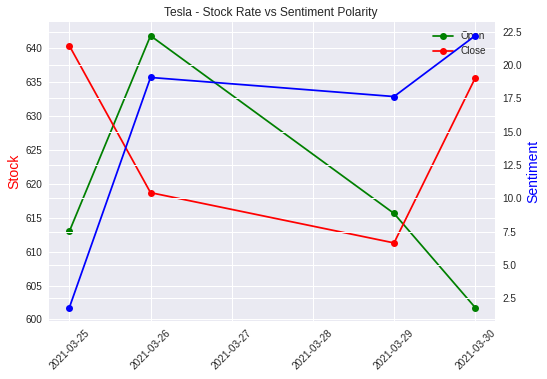

In [68]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

plt.title('Tesla - Stock Rate vs Sentiment Polarity ') # tytuł
plt.style.use("seaborn")  
plt.xticks(rotation=45)


# make a plot
ax.plot(df_merge.index,    # dane źródło 1
            df_merge["Open"],
        color="green",
        marker="o",
         label="Open"
         )
# set x-axis label
plt.legend()
# make a plot
ax.plot(df_merge.index,    # dane źródło 1
            df_merge["Close"],
        color="red",
        marker="o",
         label="Close")
ax.set_ylabel("Stock",color="red",fontsize=14)
plt.legend()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_merge.index,    # dane źródło 1
            df_merge["sentiment_polarity"], 
         color="blue",
         marker="o",
        #  label="sentiment polarity"
         )
ax2.set_ylabel("Sentiment",color="blue",fontsize=14)
# plt.legend()
plt.show()


Wnioski:
> 1. dodajmy do zestawu danych informacje o tym czy kurs akcji oraz sentyment wzrósł czy spadł 

> 2. wyniki na pewno są zakłamane ponieważ giłeda czynna jest w od poniedziałku dopiątku od godz ... do godz.
>> Tweety z soboty i niedzieli mogą mieć wpływ na akcje "open" w poniedziałek
>> Tweety z poniedziałku od zamknięcia giełdy do jej otwarcia we wtorek mogą mieć wpływ na akcje "open" . 

Dalsze możliwości:
> Strategia 1: Sprawdźmy analizę sentymentu w godzinach zamkniecia giełdy (dnia poprzedniego) np od 17:00 w poniedziałek do 8:00 we wtorek

> Strategia 2: Sprawdźmy analizę sentymentu z dnia poprzedniego i zestawmy go z "open" 


`Sposób 2 - `

- dodajmy do zestawu danych informacje o tym czy kurs akcji oraz sentyment wzrósł czy spadł
- sprawdzmy czy zachodzi korelacja 

Wnioski:
>

`Sposób 3 -`

Wnioski:
>

`Sposób 4 -`

Wnioski:
>